# Part 4. Model Comparison

## Importing libraries and setting global variables

In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling library
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

# Library to save the model
import pickle

## Importing datasets

In [2]:
def read_train_test(status='train'):
    # Function to select dataset to read
    if status == 'train':
        df = pd.read_csv('../datasets/train_cleaned.csv')
    elif status == 'test':
        df = pd.read_csv('../datasets/test_cleaned.csv')
    else:
        print(f"Select the correct dataset")
    return df

In [3]:
# Select 'train' to read train.csv
# Select 'test' to read test.csv
df = read_train_test('train')

In [4]:
# View head
df.head(5)

,ms_zoning,lot_frontage,street,lot_shape,lot_contour,utilities,lot_config,lot_slope,neighborhood,condition_1,...,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck,log_sale_price,log_lot_area
0,Res,80.0,1,1,1,AllPub,Corner,1,SawyerW,N,...,159000,0,2436.0,1,1.5,1,0,0,11.976659,9.170039
1,Res,90.0,1,0,1,AllPub,CulDSac,1,SawyerW,N,...,271900,0,4354.0,1,2.0,1,1,1,12.513190,9.594514
2,Res,60.0,1,0,1,NoSeWa,CulDSac,1,Timber,N,...,137500,0,2163.0,1,1.5,1,1,0,11.831379,9.573246
3,Res,48.0,1,1,1,AllPub,Inside,1,NridgHt,N,...,248500,0,2907.0,1,2.0,1,1,1,12.423198,8.775240
4,Res,61.0,1,0,1,AllPub,Inside,1,Gilbert,R,...,167000,1,1758.0,1,2.5,0,0,0,12.025749,9.183380


# Run model to check numerical model

#### Create function to run linear regression

In [5]:
def linreg_log(X,y,t_s=0.2,log=False):
    # model to train data - with selection of training with ln-y or y
    
    # train test split and instantiate
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=t_s,random_state=42)
    lr = LinearRegression()
    
    if log == True:
        # flow to train with ln-y
        
        # transform y to ln
        y_train_log = np.log(y_train)
        y_test_log = np.log(y_test)
        
        # fit model to ln(y)
        lr.fit(X_train,y_train_log)
        
        # predict train and test
        y_train_pred_log = lr.predict(X_train)
        y_test_pred_log = lr.predict(X_test)
        
        # exponential transform ln(y) back to y
        y_train_preds = np.exp(y_train_pred_log)
        y_test_preds = np.exp(y_test_pred_log)
        
        # print model name
        print()
        print(" Linear Log Model ".center(30, "="))
        
        # train test R^2 scores
        train_r2 = lr.score(X_train,y_train_log)
        test_r2 = lr.score(X_test,y_test_log)

        # cross validation score
        mean_cross_val = cross_val_score(lr, X_train, y_train_log)
        
    else:
        
        # fit model to y
        lr.fit(X_train,y_train)
        
        # predict train and test y
        y_train_preds = lr.predict(X_train)
        y_test_preds = lr.predict(X_test)
        
        # print model name
        print()
        print(" Linear Model ".center(30, "="))
        
        # train test score
        train_r2 = lr.score(X_train,y_train)
        test_r2 = lr.score(X_test,y_test)

        # cross validation score
        mean_cross_val = cross_val_score(lr, X_train, y_train)

    # metrics (comparing y_preds with y)
    rmse_train = round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)
    rmse_test = round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)
    
    # print model scores
    print()
    print(f"train r2: {train_r2}")
    print(f"test_r2: {test_r2}")
    print(f"mean cross val: {mean_cross_val.round(4)}")
    print(f"train rmse: {rmse_train}")
    print(f"test rmse: {rmse_test}")
    
    # create plots of predictions vs true values - to help visualize model performance
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    # correlation calculation
    cor = np.corrcoef(y_test,y_test_preds)
    
    # scatter plot (left) of y_test vs y_test_preds
    plot1 = sns.scatterplot(ax=axes[0],x=y_test,y=y_test_preds)
    sns.lineplot(ax=axes[0],x=y_test,y=y_test)
    plot1.set_xlabel('y_test')
    plot1.set_ylabel('y_test_preds')
    plot1.set_title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})")
    
    # histogram (right) of y_test vs y_test_preds
    plot2 = sns.histplot(ax=axes[1],x=y_test,color='grey',alpha=0.5)
    plot2 = sns.histplot(ax=axes[1],x=y_test_preds)
    plot2.set_xlabel('log_sale_price')
    plot2.set_title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})");
    
    return y_test,y_test_preds

In [6]:
# Count total numbers of numerical columns
print(f" Our dataset has {len(df.select_dtypes(exclude=object).columns)-2} numeric columns")

 Our dataset has 25 numeric columns


#### Model Tuning 1: Numerical only (Top 15 correlated features)

In [7]:
# Selecting top 15 correlated features from numeric columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)[:17]

In [8]:
# Selecting X and y from the dataset
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


====== Linear Log Model ======

train r2: 0.893754706561676
test_r2: 0.8855653519313933
mean cross val: [0.9034 0.8756 0.8806 0.9048 0.8855]
train rmse: 22933.95
test rmse: 23948.34


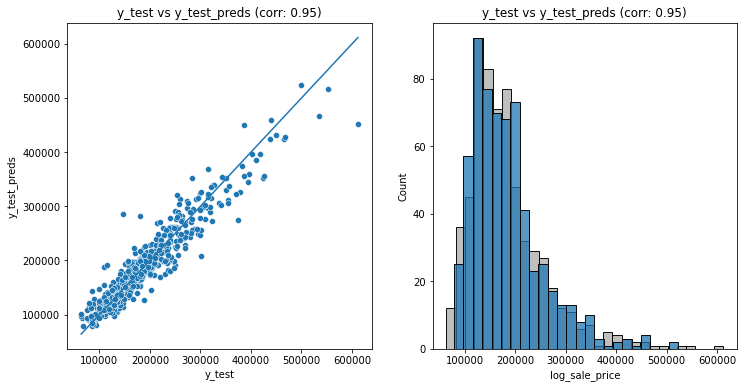

In [9]:
# running the first iteration 
y_test,y_test_preds = linreg_log(X,y,0.3,True)

----

#### Model Tuning 2: Numerical only (Top 20 correlated features)

In [10]:
# Selecting top 20 correlated (to log_sale_price) numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)[:22]

Split the data

In [11]:
# Training
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


====== Linear Log Model ======

train r2: 0.8968286412636263
test_r2: 0.8923616842272075
mean cross val: [0.9038 0.8707 0.8845 0.9042 0.8903]
train rmse: 22683.42
test rmse: 23544.95


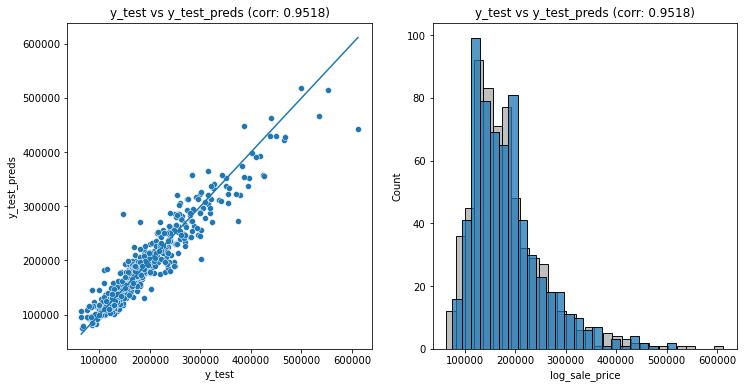

In [12]:
# running 2nd iteration
y_test,y_test_preds = linreg_log(X,y,0.3,True)

----

#### Model Tuning 3: Numerical only (All 25 features)

In [13]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

Split the data

In [14]:
# Training
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


====== Linear Log Model ======

train r2: 0.9157892031055298
test_r2: 0.9126584633271425
mean cross val: [0.9233 0.8924 0.9016 0.9227 0.9059]
train rmse: 20912.15
test rmse: 22084.26


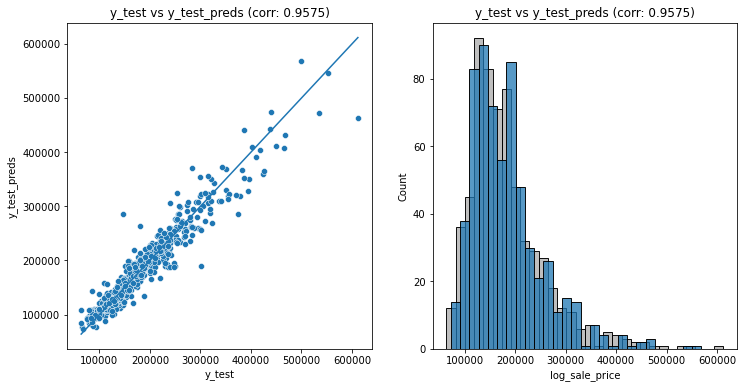

In [15]:
# running the model
y_test,y_test_preds = linreg_log(X,y,0.3,True)

----

#### Model Tuning 4: Numerical + Categorical (Quality Related Columns)

In [16]:
# Select all quality related categorical columns
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality']

In [17]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [18]:
# Combine columns
cols = num_cols + cat_cols

In [19]:
# Selecting X and y for model training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [20]:
# Get dummies for categorical columns
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


====== Linear Log Model ======

train r2: 0.9225591473432196
test_r2: 0.9166790728769633
mean cross val: [0.9299 0.8952 0.9033 0.925  0.9095]
train rmse: 19704.42
test rmse: 21084.5


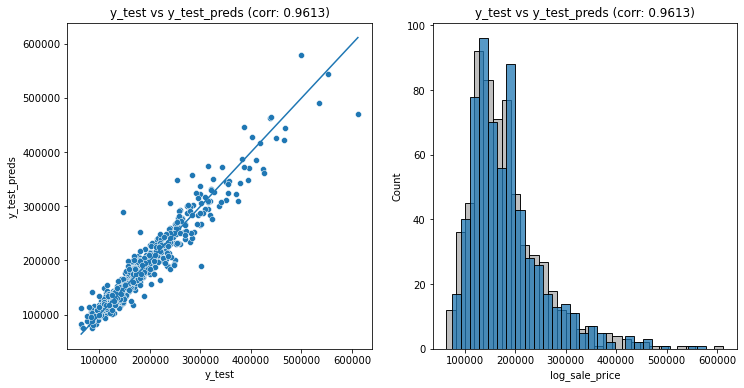

In [21]:
# Testing the model
y_test,y_test_preds = linreg_log(X,y,0.3,True)

----

#### Model Tuning 4: Numerical + Categorical (Quality Related Columns - Kitchen/External)

In [22]:
# Select quality related columns - try to reduce number of categorical
# Selecting three with more evenly distributied category couts 
# and variation in sale_price per category
cat_cols = ['external_quality','heating_quality','kitchen_quality']

In [23]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [24]:
# Combine columns
cols = num_cols + cat_cols

Split the data

In [25]:
# Training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [26]:
# Get dummies
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


====== Linear Log Model ======

train r2: 0.9201999851851651
test_r2: 0.9157470711659754
mean cross val: [0.9276 0.8954 0.9029 0.9266 0.908 ]
train rmse: 20124.5
test rmse: 21364.37


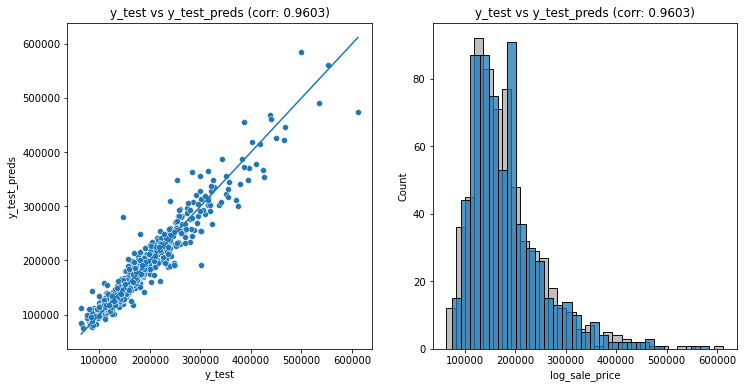

In [27]:
# Run the model
y_test,y_test_preds = linreg_log(X,y,0.3,True)

---

#### Model Tuning 5: Numerical + Categorical (All quality + Other evenly distributed category)

In [50]:
# Select quality related columns - try to reduce number of categorical
# Selecting three with more evenly distributied category couts 
# and variation in sale_price per category
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality','garage_fin','building_type','house_style','sale_type','sale_condition',
            'condition_1','masonry_type','roof_style']

In [51]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [52]:
# Combine columns
cols = num_cols + cat_cols

Split the data

In [53]:
# Training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [54]:
# Get dummies
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


====== Linear Log Model ======

train r2: 0.9305645483467601
test_r2: 0.9145396984998349
mean cross val: [0.9331 0.9112 0.9075 0.9286 0.9157]
train rmse: 18886.56
test rmse: 21113.81


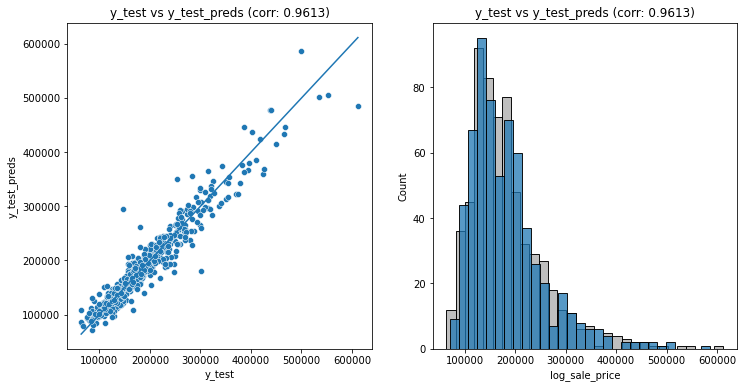

In [55]:
# Run the model
y_test,y_test_preds = linreg_log(X,y,0.3,True)

---

## Fit the selected model again to save

In [56]:
# Select all quality related categorical columns
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality','garage_fin','building_type','house_style','sale_type','sale_condition',
            'condition_1','masonry_type','roof_style']

In [57]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [58]:
# displaying columns to copy to test.csv
num_cols

['log_sale_price',
 'sale_price',
 'overall_quality',
 'total_sf',
 'garage_cars',
 'total_bath',
 'year_built',
 'has_fireplace',
 'total_rooms_above_ground',
 'has_open_porch',
 'masonry_area',
 'log_lot_area',
 'lot_frontage',
 'has_wood_deck',
 'central_air',
 'has_basement_sf',
 'bedroom_above_ground',
 'functional',
 'street',
 'has_2nd_floor_sf',
 'month_sold',
 'year_sold',
 'lot_contour',
 'lot_slope',
 'overall_condition',
 'kitchen_above_ground',
 'lot_shape']

In [59]:
# Combine columns
cols = num_cols + cat_cols

In [60]:
# Selecting X and y for model training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [61]:
# Get dummies for categorical columns
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)

In [62]:
# Instantiate and fit
lr = LinearRegression()
y_log = np.log(y)

# fit model to ln(y)
model = lr.fit(X,y_log)

# save the model
filename = 'all_num_many_cat.sav'
pickle.dump(model, open(filename, 'wb'))